#**Image Classification Model**

-The CIFAR-10 image dataset has 10 different categories of images in it.
-There is a total of 60000 images of 10 different classes naming Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.
-All the images are of size 32×32.
-There are in total 50000 train images and 10000 test images.

##Step 1: Importing the relevant librariesa and modules:

In [1]:
import tensorflow as tf

# Display the version
print(tf.__version__)

# other imports
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

2.15.0


##Step 2: Loading the data

In [2]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170498071/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


The output indicates that our dataset includes 50,000 training images and 10,000 test images. Each image has a resolution of 32x32 pixels and consists of three color channels: Red, Green, and Blue. 1 represents the number of labels per image.

In [3]:
# Labels for CIFAR-10 dataset
cifar_10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Display the naming convention of labels
for i, label_name in enumerate(cifar_10_labels):
    print(f"Label {i}: {label_name}")

Label 0: airplane
Label 1: automobile
Label 2: bird
Label 3: cat
Label 4: deer
Label 5: dog
Label 6: frog
Label 7: horse
Label 8: ship
Label 9: truck


In [4]:
from collections import defaultdict

# Assuming y_train contains the labels as integers

# Labels for CIFAR-10 dataset
cifar_10_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Flatten y_train if it's a 2D array
if len(y_train.shape) > 1:
    y_train = y_train.flatten()

# Count the number of images per label
label_counts = defaultdict(int)
for label in y_train:
    label_counts[label] += 1

# Display the number of images per label
for label in cifar_10_labels:
    print(f"{label}: {label_counts[label]}")

0: 5000
1: 5000
2: 5000
3: 5000
4: 5000
5: 5000
6: 5000
7: 5000
8: 5000
9: 5000


The labels exhibit a uniform distribution, ensuring an equal number of images per class and thereby mitigating any class imbalance concerns. Furthermore, the dataset contains an ample number of images, providing sufficient data for robust model training.

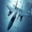

In [ ]:
#displaying a sample image
random_index = random.randint(0, len(x_train) - 1)
cv2_imshow( x_train[random_index])
cv2.waitKey(0)
cv2.destroyAllWindows()

CIFAR-10 images are small (32x32), and each image contains a single object.

##Step 3: Data Pre-processing:

Given the ample representation of each label in our dataset, with a substantial 5000 images per label, the necessity for image augmentation is alleviated. Consequently, we can confidently proceed with pixel value reduction, standardization of pixels and adding noise to make the model more robust to variations.

In [5]:
#checking the range of pixel values
min_pixel_value = np.min(x_train)
max_pixel_value = np.max(x_train)

print(f"Range of pixel values: {min_pixel_value} to {max_pixel_value}")

Range of pixel values: 0 to 255


###Reducing Pixel Values

Here, we will have to reduce the pixel values to be between 0-1 by dividing the pixels by the larges pixel in our image data, i.e, 255. Reducing pixel values to fall within the range of 0 to 1 is a common preprocessing step in machine learning, particularly for tasks involving image data. There are several reasons why this normalization is beneficial:

1. **Numerical Stability**: Neural networks and many other machine learning algorithms perform best when input values are within a small range. Normalizing pixel values to the range [0, 1] ensures that the input data falls within a well-behaved numerical range, which can lead to more stable training and better convergence.

2. **Gradient Descent**: Normalizing pixel values can help gradient descent algorithms converge more quickly. When pixel values are large (e.g., in the range [0, 255] for 8-bit images), the gradients of the loss function can also become large, which may cause oscillations or slow convergence during training. Normalizing the values to a smaller range helps mitigate this issue.

3. **Uniform Scale**: Normalizing pixel values to a common scale ensures that each feature contributes approximately proportionately to the learning process. Without normalization, features with larger numerical ranges might dominate the learning process, leading to suboptimal performance.

4. **Model Agnostic**: Normalization is a model-agnostic preprocessing step, meaning it can be applied universally across different machine learning algorithms without affecting their underlying logic.

5. **Regularization**: In some cases, normalization can act as a form of regularization, helping to prevent overfitting by constraining the input values to a specific range.

In [6]:
# Reduce pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

In [7]:
#checking the range of pixel values after reducing the pixel
min_pixel_value_train = np.min(x_train)
max_pixel_value_train = np.max(x_train)

min_pixel_value_test = np.min(x_test)
max_pixel_value_test = np.max(x_test)

print(f"Range of pixel values for the train dataset: {min_pixel_value_train} to {max_pixel_value_train}")
print(f"Range of pixel values for the test dataset: {min_pixel_value_test} to {max_pixel_value_test}")

Range of pixel values for the train dataset: 0.0 to 1.0
Range of pixel values for the test dataset: 0.0 to 1.0


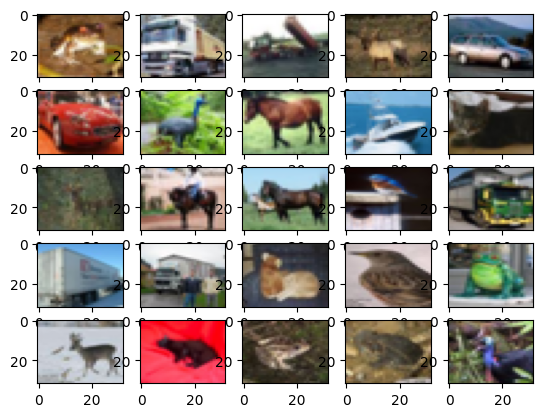

In [ ]:
# visualize data by plotting images
fig, ax = plt.subplots(5, 5)
k = 0

for i in range(5):
	for j in range(5):
		ax[i][j].imshow(x_train[k], aspect='auto')
		k += 1

plt.show()

As seen above, the image quality has reduced.

###Standardizing Pixel Values

In [8]:
#standardizing pixel values
# calculate the mean and standard deviation of the normalized pixel values
previous_mean = np.mean(x_train, axis=(0, 1, 2, 3))
previous_std = np.std(x_train, axis=(0, 1, 2, 3))

print(f"Previous mean: {previous_mean}, Previous standard deviation: {previous_std}")

# standardize the pixel values by subtracting the mean and dividing by the standard deviation
x_train = (x_train - previous_mean) / previous_std
x_test = (x_test - previous_mean) / previous_std

# serify the new mean and standard deviation
new_mean = np.mean(x_train, axis=(0, 1, 2, 3))
new_std = np.std(x_train, axis=(0, 1, 2, 3))
print(f"New mean: {new_mean}, New standard deviation: {new_std}")

Previous mean: 0.4733630004850874, Previous standard deviation: 0.25156892506322026
New mean: 9.83429634023499e-15, New standard deviation: 1.0000000000000042


**Purpose of Standardization**

**Improves Model Performance**: Many machine learning algorithms, especially neural networks, perform better when the input data has a mean of 0 and a standard deviation of 1.

**Speeds Up Convergence**: Standardized data can help gradient-based optimization algorithms converge faster.

**Prevents Numerical Instability**: It reduces the risk of numerical instability caused by large input values.

**Uniform Contribution**: Ensures that each feature (in this case, each pixel) contributes equally to the learning process, preventing any single feature from dominating due to its scale.

###Noise Addition

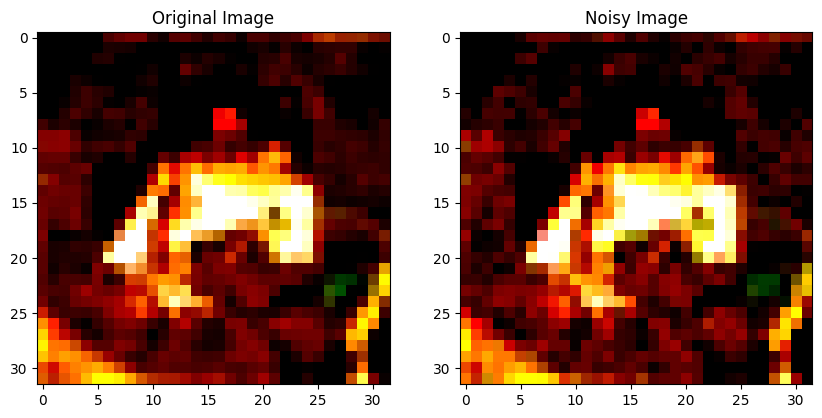

In [9]:
# adding noise
# function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    # clip the values to be between 0 and 1
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image

# example image from x_train
example_image = x_train[0]

# add noise to the image
noisy_image = add_gaussian_noise(example_image)

# plot the original and noisy images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(example_image)

plt.subplot(1, 2, 2)
plt.title('Noisy Image')
plt.imshow(noisy_image)

plt.show()

Adding random noise to images is a useful technique to make machine learning models more robust to variations and noise in the real-world data. This technique can help improve the generalization of the model by preventing it from overfitting to the training data.

##**Model Training**

We will train our model using two different approaches:

1. **Base Model-Custom CNN Model**: We will design and train a Convolutional Neural Network (CNN) from scratch by defining layers for both the encoder and decoder.

2. **Alternative Model**- Using the weights of a pre-trained model such as Efficient Net


After training both models, we will compare their performance based on accuracy and select the model that achieves the best results.

###1. **Custom CNN Model**

In [ ]:

print("number of classes:", 10)

# input layer
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

# Hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# last hidden layer i.e.. output layer
x = Dense(10, activation='softmax')(x)

model = Model(i, x)

# model description
model.summary()

# Compile
model.compile(optimizer='adam',
			loss='sparse_categorical_crossentropy',
			metrics=['accuracy'])

# Fit
output = model.fit(
x_train, y_train, validation_data=(x_test, y_test), epochs=100)

number of classes: 10
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16,

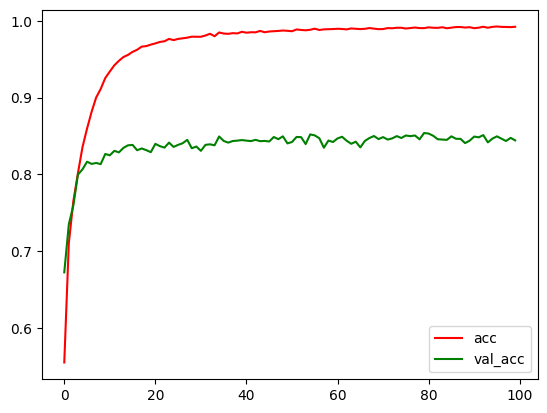

In [ ]:
# Plot accuracy per iteration
plt.plot(output.history['accuracy'], label='acc', color='red')
plt.plot(output.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

In [ ]:
# save the model
model.save('cifar_10.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/CIFAR-10 image classification/cifar_10.h5')

# Make predictions on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Calculate weighted precision, recall, and F1 score
weighted_precision = precision_score(y_test, y_pred, average='weighted')
weighted_recall = recall_score(y_test, y_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision (per class): {precision}")
print(f"Recall (per class): {recall}")
print(f"F1 Score (per class): {f1}")

print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"Weighted F1 Score: {weighted_f1}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

313/313 [==============================] - 21s 65ms/step
Accuracy: 0.8442
Precision (per class): [0.88217213 0.9241517  0.76647287 0.72875817 0.84140062 0.71812663
 0.8815261  0.92332968 0.93926702 0.8597786 ]
Recall (per class): [0.861 0.926 0.791 0.669 0.817 0.828 0.878 0.843 0.897 0.932]
F1 Score (per class): [0.87145749 0.92507493 0.77854331 0.69760167 0.8290208  0.76915931
 0.87975952 0.88133821 0.91764706 0.89443378]
Weighted Precision: 0.8464983510294516
Weighted Recall: 0.8442
Weighted F1 Score: 0.8444036075939021
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1000
           1       0.92      0.93      0.93      1000
           2       0.77      0.79      0.78      1000
           3       0.73      0.67      0.70      1000
           4       0.84      0.82      0.83      1000
           5       0.72      0.83      0.77      1000
           6       0.88      0.88      0.88      1000
           7    

1/1 [==============================] - 0s 212ms/step
Predicted Label: horse


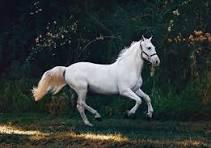

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# load the trained model
model = load_model('/content/drive/MyDrive/CIFAR-10 image classification/cifar_10.h5')

# load the image
first_image_path = '/content/drive/MyDrive/CIFAR-10 image classification/horse_image.jpg'
first_image = cv2.imread(first_image_path)

# Preprocess the image
# Resize the image to match the input size expected by the model
input_shape = (32, 32)
input_image = cv2.resize(first_image, input_shape)
input_image = np.expand_dims(input_image, axis=0)
input_image = input_image.astype('float32') / 255.0

# Perform inference
predicted_probabilities = model.predict(input_image)

# Map the predicted probabilities to class labels
labels = '''airplane automobile bird cat deer dog frog horse ship truck'''.split()
predicted_label = labels[np.argmax(predicted_probabilities)]

# Display the predicted label along with the input image
print("Predicted Label:", predicted_label)
cv2_imshow(first_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

###2. **Alternative Model**- Using the weights of a pre-trained model such as Efficient Net

Freezing and then unfreezing pre-trained model weights is a common technique in transfer learning:

1. **Freezing the Pre-trained Weights:**
   - Initially, you freeze the weights of the pre-trained layers to prevent them from being updated during the initial training phase. This means only the weights of the newly added layers will be updated.
   - This allows the model to adapt the new layers to your specific task without drastically altering the valuable features learned by the pre-trained model.

2. **Training the New Layers:**
   - Train only the new layers for a few epochs until they are reasonably well-tuned. This helps to adapt the model to the new task with minimal disruption to the learned features of the pre-trained model.

3. **Unfreezing the Weights:**
   - After the new layers have been trained, you unfreeze some or all of the pre-trained layers.
   - Fine-tune the entire model (or specific layers) with a smaller learning rate. This allows the pre-trained layers to adjust slightly and better suit the specifics of the new task without losing their previously learned features.

In [10]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#defining the number of classes
num_classes = 10
print("Number of classes:", num_classes)

#load pre-trained EfficientNetB0 model without the top layer
efficientnet_encoder = EfficientNetB0(weights='imagenet', include_top=False, input_shape=x_train[0].shape)

#freeze the encoder layers to prevent them from being updated during training
for layer in efficientnet_encoder.layers:
    layer.trainable = False

#input layer
i = Input(shape=x_train[0].shape)

#pass the input through the encoder (EfficientNetB0)
x = efficientnet_encoder(i)

#flatten the output from the encoder
x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#output layer
x = Dense(num_classes, activation='softmax')(x)

#create the model
model = Model(i, x)

#model description
model.summary()

#compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#fit the model with frozen pre-trained layers
initial_epochs = 10
output = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=initial_epochs)

#unfreeze the encoder layers for fine-tuning
for layer in efficientnet_encoder.layers:
    layer.trainable = True

#recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#fine-tune the model with both pre-trained and new layers
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

output_fine_tune = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=total_epochs, initial_epoch=output.epoch[-1])

Number of classes: 10
16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024

In [12]:
# save the model
model.save('cifar_10v3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/CIFAR-10 image classification/cifar_10v3.h5')

# Make predictions on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Calculate weighted precision, recall, and F1 score
weighted_precision = precision_score(y_test, y_pred, average='weighted')
weighted_recall = recall_score(y_test, y_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision (per class): {precision}")
print(f"Recall (per class): {recall}")
print(f"F1 Score (per class): {f1}")

print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"Weighted F1 Score: {weighted_f1}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

313/313 [==============================] - 4s 9ms/step
Accuracy: 0.6273
Precision (per class): [0.71379704 0.79222222 0.53558052 0.48236776 0.44708146 0.5864745
 0.66549912 0.69344609 0.70523416 0.71919192]
Recall (per class): [0.626 0.713 0.429 0.383 0.697 0.529 0.76  0.656 0.768 0.712]
F1 Score (per class): [0.66702184 0.75052632 0.476402   0.42697882 0.54474404 0.55625657
 0.70961718 0.67420349 0.73528004 0.71557789]
Weighted Precision: 0.6340894795795277
Weighted Recall: 0.6273
Weighted F1 Score: 0.6256608191295404
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1000
           1       0.79      0.71      0.75      1000
           2       0.54      0.43      0.48      1000
           3       0.48      0.38      0.43      1000
           4       0.45      0.70      0.54      1000
           5       0.59      0.53      0.56      1000
           6       0.67      0.76      0.71      1000
           7       

1/1 [==============================] - 3s 3s/step
Predicted Label: deer


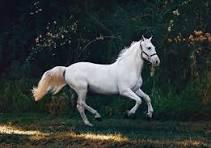

In [15]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the trained model
model = load_model('/content/drive/MyDrive/CIFAR-10 image classification/cifar_10v3.h5')

# Load the image
first_image_path = '/content/drive/MyDrive/CIFAR-10 image classification/horse_image.jpg'
first_image = cv2.imread(first_image_path)

# Preprocess the image
# Resize the image to match the input size expected by the model
input_shape = (32, 32)
input_image = cv2.resize(first_image, input_shape)
input_image = np.expand_dims(input_image, axis=0)
input_image = input_image.astype('float32') / 255.0

# Perform inference
predicted_probabilities = model.predict(input_image)

# Map the predicted probabilities to class labels
labels = '''airplane automobile bird cat deer dog frog horse ship truck'''.split()
predicted_label = labels[np.argmax(predicted_probabilities)]

# Display the predicted label along with the input image
print("Predicted Label:", predicted_label)
cv2_imshow(first_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

#Conclusion

Based on the provided information, we observe that both models underwent uniform training conditions, including:

1. Preprocessing of x_train, involving resizing, standardization, and noise addition before model input.
2. Equal training epochs for each model.

In terms of overall performance, the Base custom CNN model outperformed the alternative model utilizing pre-trained weights across all labels, showcasing superior metrics in terms of accuracy, precision, recall, and F1 score. Specifically, the Base model achieved an accuracy of 0.84, whereas the alternative model achieved 0.63.

Regarding a practical example, when presented with a test image, the Base model accurately classified the animal as a horse, while the alternative model misclassified it as a deer.

We can therefore conclude that it would be better using the Custom CNN model for this classification task.